# RSNA_Pneumonia_v001

* v001: Initial Commit

## Imports

https://pydicom.github.io/pydicom/dev/getting_started.html

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import uuid
import pydicom
import glob, pylab
import pydicom
import matplotlib.pyplot as plt
%matplotlib inline
import math
import seaborn as sns
import scipy
# add alpha (transparency) to a colormap
import matplotlib.colors 
import matplotlib.cm 
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg 
import numpy.random as random 
import seaborn as sns; sns.set()
from matplotlib.pyplot import show 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from os.path import join
from pathlib import Path
print(os.listdir("input"))

# Any results you write to the current directory are saved as output.

['dcm_data.csv', 'stage_1_detailed_class_info.csv', 'stage_1_sample_submission.csv', 'stage_1_train_labels.csv']


## Constants & Functions

Constants

In [8]:
PATH= 'input'#/rsna-pneumonia-detection-challenge/'
path_pics = str(Path.home()) + '/Downloads/stage_1_train_images'#join(PATH,'stage_1_train_images')

print(os.listdir(path_pics)[:10])

['0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', '00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm', '00322d4d-1c29-4943-afc9-b6754be640eb.dcm', '003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm', '00436515-870c-4b36-a041-de91049b9ab4.dcm', '00569f44-917d-4c86-a842-81832af98c30.dcm', '006cec2e-6ce2-4549-bffa-eadfcd1e9970.dcm', '00704310-78a8-4b38-8475-49f4573b2dbb.dcm', '008c19e8-a820-403a-930a-bc74a4053664.dcm', '009482dc-3db5-48d4-8580-5c89c4f01334.dcm']


Functions

In [92]:
class Box():
    
    def __init__(self, y, x, h, w):
        self.y, self.x, self.h, self.w = y, x, h, w
        
    def flip(self):
        return Box(self.y, 1024 - self.x-self.w, self.h, self.w)

def row2string(row):
    """
    row box to string [y, x, height, width]
    """
    if row is None:
        return ''
    elif math.isnan(row['y']):
        return ''
    else:
        return '{0}_{1}_{2}_{3}'.format(row['y'], row['x'], row['height'], row['width'])
    
def string2boxes(s):
    """
    strings to boxes [y, x, height, width]
    """
    if s == None:
        raise ArgumentException()
    elif s == '' or s == '#':
        return None
    
    boxes = []
    ss = s.split('#')
    for r in ss:
        rr = r.split('_')
        try:
            box = Box(float(rr[0]), float(rr[1]), float(rr[2]), float(rr[3]))
            boxes.append(box)
        except:
            continue
        
    return boxes

def draw(data, auto_flip=True, write_info=False):
    """
    Method to draw single patient with bounding box(es) if present 
    """
    name_pic = data['patientId'] + '.dcm'
    fullpath_pic = join(path_pics, name_pic)

    # --- Open DICOM file
    d = pydicom.read_file(fullpath_pic)
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    boxes = string2boxes(data['boxes'])
    
    # print data
    if write_info:
        print(d)

    if(auto_flip and data['View Position'] == 'AP'):
        im = np.flip(im, 1)
        for i, box in enumerate(boxes):
            boxes[i] = box.flip()
    
    if(boxes != None):
        for box in boxes:
            im = overlay_box(im=im, box=box, rgb=[255, 0, 0], stroke=6)

    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap=pylab.cm.gist_gray)

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image
    """
    
    # --- Extract coordinates
    y1, x1, height, width = int(box.y), int(box.x), int(box.h), int(box.w)
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im
import scipy.misc

def save_png(data):
    """
    Method to save as png
    """
    name_pic = data['patientId'] + '.dcm'
    print(data['patientId'])
    fullpath_pic = join(path_pics, name_pic)

    # --- Open DICOM file
    d = pydicom.read_file(fullpath_pic)
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    #scipy.misc.imsave(join(path_pics, data['patientId']), im)
    scipy.misc.toimage(im, cmin=0.0, cmax=255).save(join(path_pics, data['patientId']))


def PDFonImage(file_name, matrix):
    wd = matplotlib.cm.winter._segmentdata # only has r,g,b  
    wd['alpha'] =  ((0.0, 0.0, 0.3), 
                   (0.3, 0.3, 1.0),
                   (1.0, 1.0, 1.0))

    # modified colormap with changing alpha
    al_winter = LinearSegmentedColormap('AlphaWinter', wd) 


    fullpath_pic = join(path_pics, file_name)
    # get the map image as an array so we can plot it 
    dcm_data = pydicom.read_file(fullpath_pic)
    im = dcm_data.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)
    
    if dcm_data.ViewPosition == 'AP':
        im = np.flip(im, 1)

    # making and plotting heatmap 
    plt.figure(figsize=(13,13))
    hmax = sns.heatmap(matrix,
                #cmap = al_winter, # this worked but I didn't like it
                #cmap = matplotlib.cm.winter,
                alpha = 0.5, # whole heatmap is translucent
                annot = True,
                zorder = 2,
                square=True,
                fmt='.2f',
                annot_kws={"size":8},
                xticklabels=[int((i+1) / dw) for i in range(matrix.shape[0])], 
                yticklabels=[int((i+1) / dw) for i in range(matrix.shape[0])] 
                )

    # heatmap uses pcolormesh instead of imshow, so we can't pass through 
    # extent as a kwarg, so we can't mmatch the heatmap to the map. Instead, 
    # match the map to the heatmap:

    hmax.imshow(im,
              aspect = hmax.get_aspect(),
              extent = hmax.get_xlim() + hmax.get_ylim(),
              zorder = 1) #put the map under the heatmap

    show()

In [10]:
train_label = pd.read_csv(join(PATH,'stage_1_train_labels.csv'))
detailed_class = pd.read_csv(join(PATH,'stage_1_detailed_class_info.csv'))

In [11]:
train_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28989 entries, 0 to 28988
Data columns (total 6 columns):
patientId    28989 non-null object
x            8964 non-null float64
y            8964 non-null float64
width        8964 non-null float64
height       8964 non-null float64
Target       28989 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.3+ MB


Build complete DataFrame
* Make a single string out of all the boxes relative to a single patient
* Add pic's properties to df

In [12]:
df = pd.merge(train_label, detailed_class, on='patientId')
df = pd.concat([df, pd.get_dummies(df['class'])], axis=1)

Execute the following code if generating the db

In [13]:
name_pic = pd.read_csv(join(PATH,'dcm_data.csv'), index_col=0)
name_pic['Age'] = name_pic['Age'].astype(int)
name_pic.head()

,Age,Sex,View Position,boxes,patientId
0,51,F,PA,#,0004cfab-14fd-4e49-80ba-63a80b6bddd6
1,48,F,PA,#,00313ee0-9eaa-42f4-b0ab-c148ed3241cd
2,19,M,AP,#,00322d4d-1c29-4943-afc9-b6754be640eb
3,28,M,PA,#,003d8fa0-6bf1-40ed-b54c-ac657f8495c5
4,32,F,AP,NaN,00436515-870c-4b36-a041-de91049b9ab4


In [14]:
df = pd.concat([df, name_pic.drop('patientId', axis=1)], axis=1)
df = df.drop(['x', 'y', 'width', 'height'], axis=1)
df = df.dropna(axis=0, subset=['boxes'])
df.head()

,patientId,Target,class,Lung Opacity,No Lung Opacity / Not Normal,Normal,Age,Sex,View Position,boxes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,No Lung Opacity / Not Normal,0,1,0,51,F,PA,#
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,No Lung Opacity / Not Normal,0,1,0,48,F,PA,#
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,No Lung Opacity / Not Normal,0,1,0,19,M,AP,#
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,Normal,0,0,1,28,M,PA,#
7,00436515-870c-4b36-a041-de91049b9ab4,1,Lung Opacity,1,0,0,32,F,AP,#152.0_264.0_379.0_213.0#152.0_264.0_379.0_213...


In [15]:
len(df['patientId']) == len( set(df['patientId']))

True

In [16]:
gna = df[df['No Lung Opacity / Not Normal'] == 1]
print('No Lung Opacity / Not Normal classified as 1= {0}'.format(len(gna[gna['boxes'] != '#'])))

No Lung Opacity / Not Normal classified as 1= 0


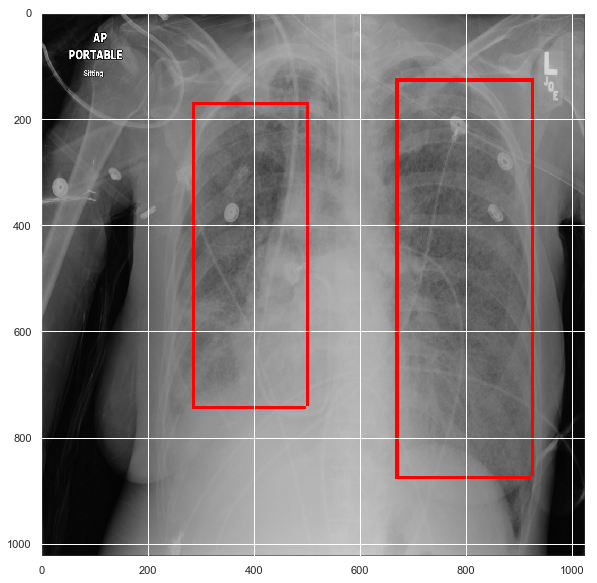

In [59]:
draw(df.iloc[100], auto_flip=False, write_info=False)

## Analysis

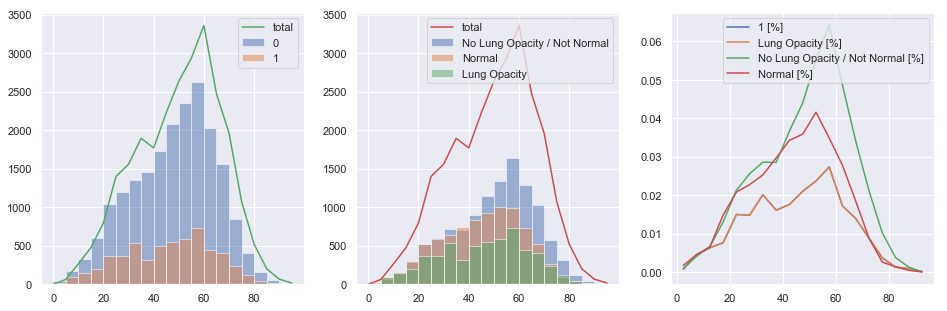

In [18]:
bins = range(0,100,5)
plt.figure(figsize=(16,5))

#plt.figure(1)
plt.subplot(1,3,1)
age_1 = df[['Age', 'Target']][df['Target'] ==1]
age_0 = df[['Age', 'Target']][df['Target'] ==0]

a, _, _ = plt.hist(age_0.sort_values('Age')['Age'], bins, alpha=0.5, label='0')
b, _, _ = plt.hist(age_1.sort_values('Age')['Age'], bins, alpha=0.5, label='1')
plt.plot(range(0,100,5),[0]+[a+b for a,b in zip(*[a,b])], label='total')
plt.legend()


plt.subplot(1,3,2)
lung_opac = df[['Age', 'Target']][df['Lung Opacity'] ==1]
lung_boh = df[['Age', 'Target']][df['No Lung Opacity / Not Normal'] ==1] 
lung_norm = df[['Age', 'Target']][df['Normal'] ==1]

a, _, _ = plt.hist(lung_boh.sort_values('Age')['Age'], bins, alpha=0.5, label='No Lung Opacity / Not Normal')
b, _, _ = plt.hist(lung_norm.sort_values('Age')['Age'], bins, alpha=0.5, label='Normal')
c, _, _ = plt.hist(lung_opac.sort_values('Age')['Age'], bins, alpha=0.5, label='Lung Opacity')
plt.plot(range(0,100,5),[0]+[a+b+c for a,b,c in zip(*[a,b,c])], label='total')
plt.legend()


plt.subplot(1,3,3)
g = pd.cut(df.sort_values('Age')['Age'], bins)
g = df.groupby(g, sort=False)
g_t = g['Target'].aggregate('sum') / len(df)
g_opac = g['Lung Opacity'].aggregate('sum') / len(df)
g_boh = g['No Lung Opacity / Not Normal'].aggregate('sum') / len(df)
g_norm = g['Normal'].aggregate('sum') / len(df)

plt.plot([x.mid for x in g_t.index], g_t, label='1 [%]')
plt.plot([x.mid for x in g_t.index], g_opac, label='Lung Opacity [%]')
plt.plot([x.mid for x in g_t.index], g_boh , label='No Lung Opacity / Not Normal [%]')
plt.plot([x.mid for x in g_t.index], g_norm, label='Normal [%]')
#plt.plot([(a,b) for a,b in zip(*[g_norm.values, g_boh.values])])

plt.legend()
plt.show()

## Correlations

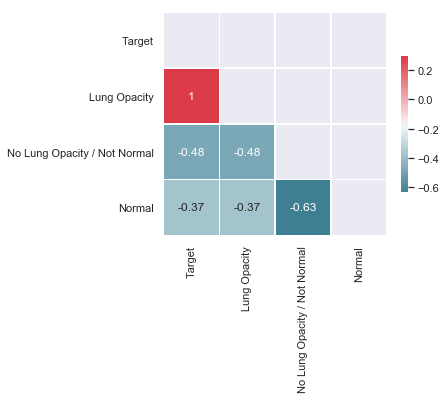

In [19]:
corr = df[['Target', 'Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True)

Percent classification according to age

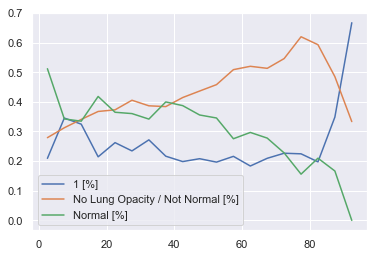

In [20]:
g = pd.cut(df.sort_values('Age')['Age'], bins)
g = df.groupby(g, sort=False)

g_t = g['Target'].aggregate('sum') / g['Target'].aggregate('count')
#g_opac = g['Lung Opacity'].aggregate('sum') / g['Target'].aggregate('count')
g_boh = g['No Lung Opacity / Not Normal'].aggregate('sum') / g['Target'].aggregate('count')
g_norm = g['Normal'].aggregate('sum') / g['Target'].aggregate('count')

plt.plot([x.mid for x in g_t.index], g_t, label='1 [%]')
#plt.plot([x.mid for x in g_t.index], g_opac, label='Lung Opacity [%]')
plt.plot([x.mid for x in g_t.index], g_boh , label='No Lung Opacity / Not Normal [%]')
plt.plot([x.mid for x in g_t.index], g_norm, label='Normal [%]')

plt.legend()
plt.show()

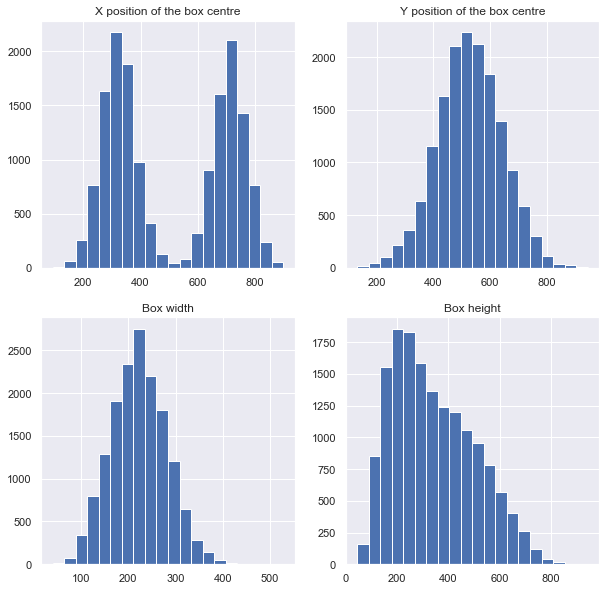

In [60]:
x = []; y = []; w = []; h = []

for s in df['boxes'].iteritems():
    boxes = string2boxes( s[1])
    
    if boxes == None: continue
    
    for b in boxes:
        
        if df.iloc[i]['View Position'] == 'AP':
            b = box.flip()
        
        x.append(b.x + b.w/2)
        y.append(b.y + b.h/2)
        w.append(b.w)
        h.append(b.h)

boxes = pd.DataFrame({'x': x, 'y':y, 'h':h, 'w':w}, dtype=int)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(x, 20)
plt.title('X position of the box centre')
plt.subplot(2,2,2)
plt.hist(y, 20)
plt.title('Y position of the box centre')
plt.subplot(2,2,3)
plt.hist(w, 20)
plt.title('Box width')
plt.subplot(2,2,4)
plt.hist(h, 20)
plt.title('Box height')
plt.show()

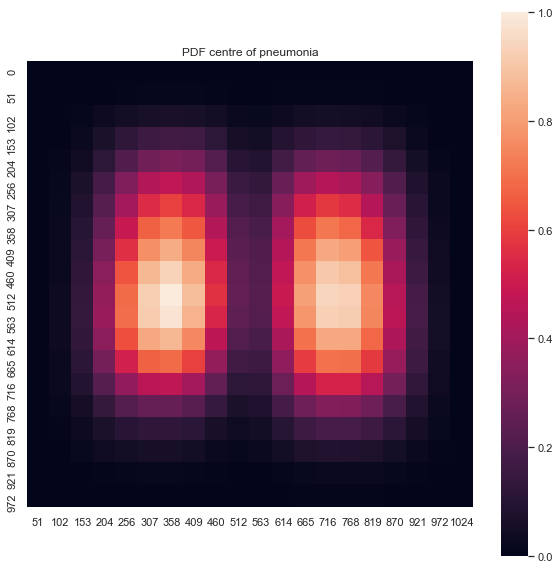

In [81]:
box_bins = 20

matrix = np.zeros(shape=(box_bins, box_bins))
dw = box_bins/1024
for i, row in boxes.iterrows():
    x_i = row['x'] * dw
    y_i = row['y'] * dw
    w_i = row['w'] * dw
    h_i = row['h'] * dw
    
    xx_i = int(round(x_i + w_i/2))
    yy_i = int(round(y_i + h_i/2))
    x_i = int(round(x_i - w_i/2))
    y_i = int(round(y_i - h_i/2))
    
    matrix[y_i:yy_i, x_i:xx_i] += 1
    
matrix = matrix / matrix.max()

fig = plt.figure(figsize=(10,10))

sns.heatmap(matrix, 
            square =True,
            xticklabels=[int((i+1) / dw) for i in range(box_bins)], 
            yticklabels=[int((i+1) / dw) for i in range(box_bins)] 
           )

plt.title('PDF centre of pneumonia')
plt.draw()

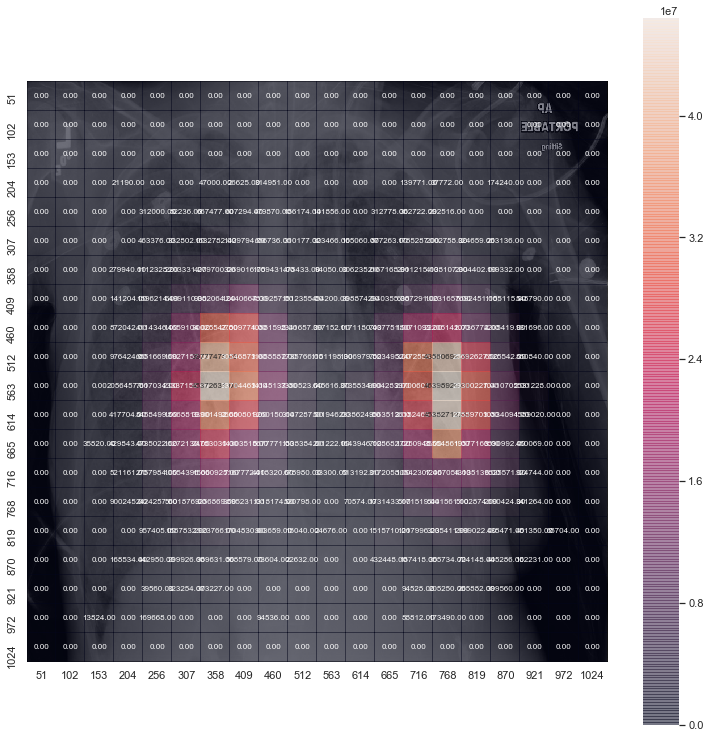

In [96]:
file_name = df.iloc[100]['patientId'] + '.dcm'

PDFonImage(file_name, matrix)

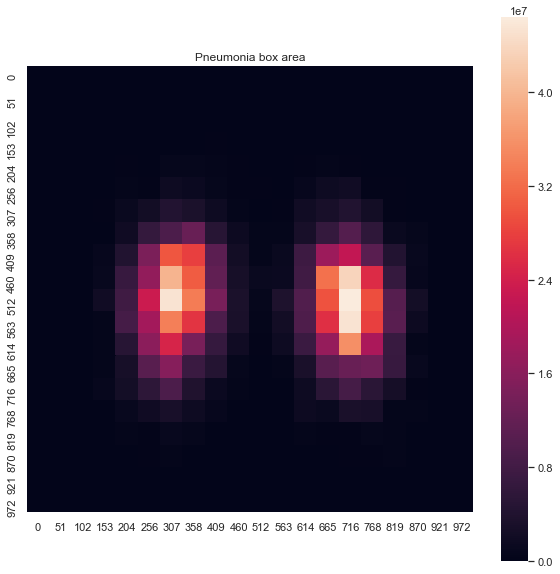

In [95]:
matrix = np.zeros(shape=(box_bins, box_bins))
dw = box_bins/1024

for i, row in boxes.iterrows():
    x_i = row['x'] * dw
    y_i = row['y'] * dw
    w = row['w']
    h = row['h']
    
    x_i = int(round(x_i))
    y_i = int(round(y_i))
    
    matrix[y_i:y_i+1, x_i:x_i+1] +=  w*h
    
# matrix = matrix / matrix.max()

fig = plt.figure(figsize=(10,10))

sns.heatmap(matrix, 
            square =True,
            xticklabels=[int(i / dw) for i in range(box_bins)], 
            yticklabels=[int(i / dw) for i in range(box_bins)] 
           )

plt.title('Pneumonia box area')
plt.draw()